<a href="https://colab.research.google.com/github/s-whynot/Bearing_Fault_CWRU/blob/main/10_Classes_CWRU_Fault__Detection_DEtoFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fault detection for rolling element bearings with Keras and Tensorflow

# 1.Introduction 
The original dataset is from the [Case Western Reserve University](http://csegroups.case.edu/bearingdatacenter/home). This is where the fault data comes from, which is used to classify faults using a CNN (Convolutional Neural Network). 
I have uploaded this data to [Github](https://github.com/s-whynot/CWRU-dataset). With this, I downloaded my own, verified true CWRU bearing data. 

In [1]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 

# 2.Download the dataset

The dataset is downloaded from the [Github](https://github.com/s-whynot/CWRU-dataset) repository.  The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for normal state, not damaged
     - `B` for ball damaged
     - `IR` for inner raceway damage
     - `OR` for outer raceway damage
2. **Fault Diameter** -
    - `007` for 0.007 inch or 7 mils damage
    - `014` for 0.014 inch damage 
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor** 
    - *3*, *6*, *12* for **OUTER RACEWAY** faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

In [2]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/s-whynot/CWRU-dataset/archive/main.zip'

r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content)
    #f.close() 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 3.Edit the downloaded data

Using the data collected at the *Drive End* or *Fan End*, which is labelled with the code `FE` or `DE`. This function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix. 

The function also converts the unit to SI.

## 3.1 Functions used

In [3]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data.
- All subfolders are recursively scanned with the function `fast_scandir`.

In [4]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    print(file_path, files_list[i])
    sig = acceleration_time_signal(data, code)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  #display(G_data.shape)
  return G_data 

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent 
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting FE data by percent of DE data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders 

##3.2 Normal Acceleration data
DE and FE

In [5]:
#12k Normal Signal for FE & DE
file_path_1 = '/content/CWRU-dataset-main/Normal/'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]
#print(onlyfiles_1)

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
G_data_N_FE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "FE")
display(G_data_N_DE.shape)
display(G_data_N_FE.shape)

/content/CWRU-dataset-main/Normal/ 98_Normal_1.mat
/content/CWRU-dataset-main/Normal/ 97_Normal_0.mat
/content/CWRU-dataset-main/Normal/ 99_Normal_2.mat
/content/CWRU-dataset-main/Normal/ 100_Normal_3.mat
/content/CWRU-dataset-main/Normal/ 98_Normal_1.mat
/content/CWRU-dataset-main/Normal/ 97_Normal_0.mat
/content/CWRU-dataset-main/Normal/ 99_Normal_2.mat
/content/CWRU-dataset-main/Normal/ 100_Normal_3.mat


(1698547,)

(1698547,)

##3.3 12000 Hz DE data 
for faults -
1. B, 
2. IR, 
3. OR

In [6]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/'
subfolder_path = fast_scandir(file_path_2)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    #print(dir_1, onlyfiles_2_1)

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
  #B
  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    #print(dir_1, onlyfiles_2_2)

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
  #IR
  #OR
  elif 'OR/' in dir_1:
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    #print(dir_1, onlyfiles_2_3)
    if '007' in dir_1:
      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        #print(dir_1, onlyfiles_2_3[i])
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)
    elif '014' in dir_1:
      #014
      #print(dir_1)
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")
    else:
      #021
      for i in range(len(onlyfiles_2_3)):
        #print(dir_1, onlyfiles_2_3[i])
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)
  #OR 
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)     

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 199@6_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 200@6_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 198@6_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 197@6_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 212_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 211_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 209_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 210_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3001_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3003_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3002_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3004_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/0

##3.4 12000 Hz FE data 
for faults -
1. B, 
2. IR, 
3. OR

In [7]:
#12k FE data load
file_path_3 = '/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/'
subfolder_path_3 = fast_scandir(file_path_3)
#print(subfolder_path_3)

G_data_OR_007_FE = []
G_data_OR_014_FE = []
G_data_OR_021_FE = []

for i in range(3, len(subfolder_path_3), 1):
  dir_2 = subfolder_path_3[i]
  #B
  if 'B/' in dir_2:
    onlyfiles_3 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3)
    if '007' in dir_2:
      #007
      G_data_B_007_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
    elif '014' in dir_2:
      #014
      G_data_B_014_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
    else:
      #021
      G_data_B_021_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
  #B
  #IR
  elif 'IR/' in dir_2:
    onlyfiles_3_2 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3_2)
    if '007' in dir_2:
      #007
      G_data_IR_007_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
    elif '014' in dir_2:
      #014
      G_data_IR_014_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
    else:
      #021
      G_data_IR_021_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
  #IR
  #OR
  elif 'OR/' in dir_2:
    onlyfiles_3_3 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3_3)
    if '007' in dir_2:
    #007
      for i in range(len(onlyfiles_3_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_007 = acceleration_time_signal(data_OR_007, code='FE')
        G_data_OR_007_FE.append(or_sig_007)
    elif '014' in dir_2:
    #014
      for i in range(len(onlyfiles_3_3)):
        data_OR_014 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_014 = acceleration_time_signal(data_OR_014, code='FE')
        G_data_OR_014_FE.append(or_sig_014)
    else:
    #021
      for i in range(len(onlyfiles_3_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_021 = acceleration_time_signal(data_OR_021, code='FE')
        G_data_OR_021_FE.append(or_sig_021)
  #OR

print("G_data_B_007_FE", G_data_B_007_FE.shape)
print("G_data_B_014_FE", G_data_B_014_FE.shape)
print("G_data_B_021_FE", G_data_B_021_FE.shape)

print("G_data_IR_007_FE", G_data_IR_007_FE.shape)
print("G_data_IR_014_FE", G_data_IR_014_FE.shape)
print("G_data_IR_021_FE", G_data_IR_021_FE.shape)

G_data_OR_007_FE = np.vstack(G_data_OR_007_FE).flatten()
print("G_data_OR_007_FE", G_data_OR_007_FE.shape)
G_data_OR_014_FE = np.vstack(G_data_OR_014_FE).flatten()
print("G_data_OR_014_FE", G_data_OR_014_FE.shape)
G_data_OR_021_FE = np.vstack(G_data_OR_021_FE).flatten()
print("G_data_OR_021_FE", G_data_OR_021_FE.shape)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 273_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 272_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 271_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 270_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 281_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 279_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 280_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 278_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 276_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 277_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 274_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 275_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/021 292_2.mat
/content/CWRU-dataset-main

### 3.4.1 Target Domain split
Separating 90% for the Test
1. B, 
2. IR, 
3. OR

10% split is done for Transfer Learning. The 12k FE data is the *Target Domain* from which 90% is taken for Test and Validation.


In [8]:
G_data_N_FE_train, G_data_N_FE_test_1 = Percent_data_split(G_data_N_FE, False) 
print("G_data_N_FE_train", G_data_N_FE_train.shape)
print("G_data_N_FE_test 1", G_data_N_FE_test_1.shape)

G_data_B_007_FE_train, G_data_B_007_FE_test_1 = Percent_data_split(G_data_B_007_FE, False) 
print("G_data_B_007_FE_train", G_data_B_007_FE_train.shape)
print("G_data_B_007_FE_test 1", G_data_B_007_FE_test_1.shape)
G_data_B_014_FE_train, G_data_B_014_FE_test_1 = Percent_data_split(G_data_B_014_FE, False) 
print("G_data_B_014_FE_train", G_data_B_014_FE_train.shape)
print("G_data_B_014_FE_test 1", G_data_B_014_FE_test_1.shape)
G_data_B_021_FE_train, G_data_B_021_FE_test_1 = Percent_data_split(G_data_B_021_FE, False) 
print("G_data_B_021_FE_train", G_data_B_021_FE_train.shape)
print("G_data_B_021_FE_test 1", G_data_B_021_FE_test_1.shape)

G_data_IR_007_FE_train, G_data_IR_007_FE_test_1 = Percent_data_split(G_data_IR_007_FE, False) 
print("G_data_IR_007_FE_train", G_data_IR_007_FE_train.shape)
print("G_data_IR_007_FE_test 1", G_data_IR_007_FE_test_1.shape)
G_data_IR_014_FE_train, G_data_IR_014_FE_test_1 = Percent_data_split(G_data_IR_014_FE, False) 
print("G_data_IR_014_FE_train", G_data_IR_014_FE_train.shape)
print("G_data_IR_014_FE_test 1", G_data_IR_014_FE_test_1.shape)
G_data_IR_021_FE_train, G_data_IR_021_FE_test_1 = Percent_data_split(G_data_IR_021_FE, False) 
print("G_data_IR_021_FE_train", G_data_IR_021_FE_train.shape)
print("G_data_IR_021_FE_test 1", G_data_IR_021_FE_test_1.shape)

G_data_OR_007_FE_train, G_data_OR_007_FE_test_1 = Percent_data_split(G_data_OR_007_FE, False) 
print("G_data_OR_007_FE_train", G_data_OR_007_FE_train.shape)
print("G_data_OR_007_FE_test 1", G_data_OR_007_FE_test_1.shape)
G_data_OR_014_FE_train, G_data_OR_014_FE_test_1 = Percent_data_split(G_data_OR_014_FE, False) 
print("G_data_OR_014_FE_train", G_data_OR_014_FE_train.shape)
print("G_data_OR_014_FE_test 1", G_data_OR_014_FE_test_1.shape)
G_data_OR_021_FE_train, G_data_OR_021_FE_test_1 = Percent_data_split(G_data_OR_021_FE, G_data_OR_021_FE, 9.9, False) 
print("G_data_OR_021_FE_train", G_data_OR_021_FE_train.shape)
print("G_data_OR_021_FE_test 1", G_data_OR_021_FE_test_1.shape)

G_data_N_FE_train (169854,)
G_data_N_FE_test 1 (1528693,)
G_data_B_007_FE_train (48485,)
G_data_B_007_FE_test 1 (436371,)
G_data_B_014_FE_train (48724,)
G_data_B_014_FE_test 1 (438518,)
G_data_B_021_FE_train (48503,)
G_data_B_021_FE_test 1 (436535,)
G_data_IR_007_FE_train (48577,)
G_data_IR_007_FE_test 1 (437195,)
G_data_IR_014_FE_train (48522,)
G_data_IR_014_FE_test 1 (436699,)
G_data_IR_021_FE_train (48448,)
G_data_IR_021_FE_test 1 (436040,)
G_data_OR_007_FE_train (145658,)
G_data_OR_007_FE_test 1 (1310927,)
G_data_OR_014_FE_train (60565,)
G_data_OR_014_FE_test 1 (545090,)
G_data_OR_021_FE_train (47836,)
G_data_OR_021_FE_test 1 (435366,)


##**3.5** G data for a single file IR DE data

It is a python dictionary with keys where
* `code` is the sensor position and can be:
    - `DE` if the data comes from the sensor at the *Drive End* of the motor
    - `FE` if the data comes from the sensor at the *Fan End* of the engine
    

In [10]:
for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  if 'IR/' in dir_1:
    onlyfiles = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    if '007' in dir_1:
    #007
      #print(dir_1, onlyfiles)
      #G_data_IR_007 = Read_MAT_files_from_folders(dir_1, onlyfiles, "DE")
      data = sio.loadmat(os.path.join(dir_1, onlyfiles[0]))
      print(dir_1, onlyfiles[0])
      print("MAT File content: ", data)
      G_data = acceleration_time_signal(data, code='FE')
      print("Just the G data: ", G_data) 

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007 106_1.mat
MAT File content:  {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 13:50:54 2000', '__version__': '1.0', '__globals__': [], 'X106_DE_time': array([[-0.27760164],
       [-0.04434479],
       [ 0.11760303],
       ...,
       [ 0.17234367],
       [ 0.12263852],
       [ 0.01884248]]), 'X106_FE_time': array([[ 0.04088545],
       [ 0.06985455],
       [ 0.33776727],
       ...,
       [-0.08423636],
       [-0.05608909],
       [-0.24531273]]), 'X106_BA_time': array([[ 0.07922742],
       [ 0.00716226],
       [-0.04023739],
       ...,
       [ 0.01854944],
       [ 0.02913187],
       [ 0.09306908]]), 'X106RPM': array([[1772]], dtype=uint16)}
Just the G data:  [[ 0.00103849]
 [ 0.00177431]
 [ 0.00857929]
 ...
 [-0.0021396 ]
 [-0.00142466]
 [-0.00623094]]


##**3.6** Plot
Some signals are plotted for the position code = `FE`of the train data. The data is sampled at 12kHz, that is 12000 data points per second. Plot is done for 1/10 or 10% of 1 second: 

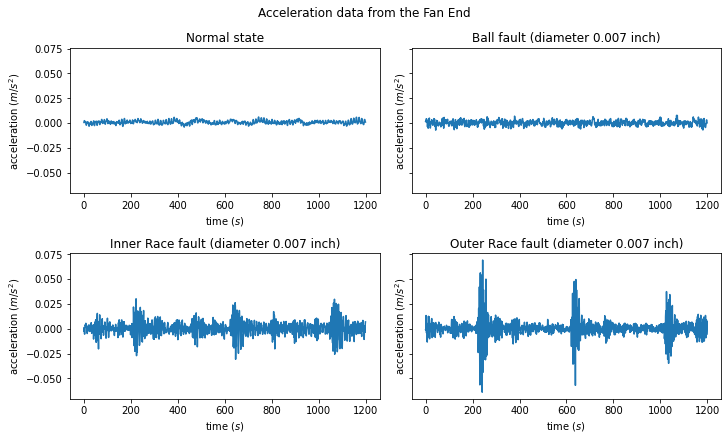

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = range(0,1200)

# plotting
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Acceleration data from the Fan End')

axs[0, 0].plot(G_data_N_FE_train[range_of_samples])
axs[0, 0].set_title('Normal state')

axs[0, 1].plot(G_data_B_007_FE_train[range_of_samples])
axs[0, 1].set_title('Ball fault (diameter 0.007 inch)')

axs[1, 0].plot(G_data_IR_007_FE_train[range_of_samples])
axs[1, 0].set_title('Inner Race fault (diameter 0.007 inch)')

axs[1, 1].plot(G_data_OR_007_FE_train[range_of_samples])
axs[1, 1].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='acceleration $(m/s^2)$')


# 4.Preprocessing and the architecture of the CNN


This has been accomplished with the help of [this Github rep](https://github.com/dimitardi/deep-predict). 

The different preprocessing phases are - 

1. Data in chunks
2. Feature engineering
3. Image creating
4. Image loading
5. Data shuffling
6. Convolutional Neural Network (CNN)

## 4.1 Data in chunks

1. Acceleration data or signal is divided in chunks of size `chunk_size` and a subset `number_of_chunks` from all of it that is available for training and testing the CNN. 

2. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. 

3. Every chunk is distinct - no overlapping samples in different chunks. 

4. This method is _tumbling time windowing_, more information in [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). 

5. Each time series is an array, with small length differences. For a fixed chunk size to divide the file, a function needs to split the data exaclty in `number_of_chunks` of `chunk_size` and **ignore** the remaining part. 

6. A function for that - `split_exact`, takes the array for splitting, the number of chunks and the array axis to be split into. 

7. Whole dataset remains but the vector has been divided into column chunks to build a matrix. It makes passing the *whole dataset* through easier and takes *less time* for the data to load in general.

In [12]:
def split_exact(x, n_chunks=2, axis=1):
    import numpy as np
    l = np.shape(x)[axis]
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        if axis == 0:
            x_split = np.split(x[:-(l % n)], n, axis=axis)
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n, axis=axis)
    return x_split

The data went through some operations. Ignoring the 0.028 inch fault diameter from `IR` and `B`, only considering the rest:

* the **normal** data labelled as `N`
* the **inner raceway** data labelled as `IR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **ball** damage data labelled as `B`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **outer raceway** data labelled as `OR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter

For every load, data is joined from `0...3` HP load, normalizing it with respect to the *standard deviation*. This is because the load is not considered in *Classification*. 

Several functions needed, such as; `load_raw_matlab_data` which returns several multidimensional arrays for `N`, `IR`, `B` and `OR` data with dimension of the maximum `number_of_chunks` obtainable from the data, by `chunk_size`. 

In [13]:
import numpy as np

def g_data_chunkSplit(gdata, chunk_size=128):
    """
    Change loaded mat files and splits it in chunks of size chunk_size
    """
    y_n: ndarray = np.array([])
    # signal
    x = gdata
    x = x / np.std(x)
    y_n = np.append(y_n, x)
    n_splits = len(y_n) // chunk_size
    y_n = split_exact(y_n, n_chunks=n_splits, axis=0)
    
    return y_n

Initializing the data using the latter function.

In [16]:
chunk_size = 1200
number_of_chunks = 1400

#FE data 
normal_data_chunk_FE_train = g_data_chunkSplit(G_data_N_FE_train, chunk_size=chunk_size)
print("normal_data_chunk_FE_train", np.shape(normal_data_chunk_FE_train))
normal_data_chunk_FE_test = g_data_chunkSplit(G_data_N_FE_test_1, chunk_size=chunk_size)
print("normal_data_chunk_FE_test", np.shape(normal_data_chunk_FE_test))

b_data_chunk_007_FE_train = g_data_chunkSplit(G_data_B_007_FE_train, chunk_size=chunk_size)
print("b_data_chunk_007_FE_train", np.shape(b_data_chunk_007_FE_train))
b_data_chunk_007_FE_test = g_data_chunkSplit(G_data_B_007_FE_test_1, chunk_size=chunk_size)
print("b_data_chunk_007_FE_test", np.shape(b_data_chunk_007_FE_test))
b_data_chunk_014_FE_train = g_data_chunkSplit(G_data_B_014_FE_train, chunk_size=chunk_size)
print("b_data_chunk_014_FE_train", np.shape(b_data_chunk_014_FE_train))
b_data_chunk_014_FE_test = g_data_chunkSplit(G_data_B_014_FE_test_1, chunk_size=chunk_size)
print("b_data_chunk_014_FE_test", np.shape(b_data_chunk_014_FE_test))
b_data_chunk_021_FE_train = g_data_chunkSplit(G_data_B_021_FE_train, chunk_size=chunk_size)
print("b_data_chunk_021_FE_train", np.shape(b_data_chunk_021_FE_train))
b_data_chunk_021_FE_test = g_data_chunkSplit(G_data_B_021_FE_test_1, chunk_size=chunk_size)
print("b_data_chunk_021_FE_test", np.shape(b_data_chunk_021_FE_test))  

ir_data_chunk_007_FE_train = g_data_chunkSplit(G_data_IR_007_FE_train, chunk_size=chunk_size)
print("ir_data_chunk_007_FE_train", np.shape(ir_data_chunk_007_FE_train))
ir_data_chunk_007_FE_test = g_data_chunkSplit(G_data_IR_007_FE_test_1, chunk_size=chunk_size)
print("ir_data_chunk_007_FE_test", np.shape(ir_data_chunk_007_FE_test))
ir_data_chunk_014_FE_train = g_data_chunkSplit(G_data_IR_014_FE_train, chunk_size=chunk_size)
print("ir_data_chunk_014_FE_train", np.shape(ir_data_chunk_014_FE_train))
ir_data_chunk_014_FE_test = g_data_chunkSplit(G_data_IR_014_FE_test_1, chunk_size=chunk_size)
print("ir_data_chunk_014_FE_test", np.shape(ir_data_chunk_014_FE_test))
ir_data_chunk_021_FE_train = g_data_chunkSplit(G_data_IR_021_FE_train, chunk_size=chunk_size)
print("ir_data_chunk_021_FE_train", np.shape(ir_data_chunk_021_FE_train))
ir_data_chunk_021_FE_test = g_data_chunkSplit(G_data_IR_021_FE_test_1, chunk_size=chunk_size)
print("ir_data_chunk_021_FE_test", np.shape(ir_data_chunk_021_FE_test))

or_data_chunk_007_FE_train = g_data_chunkSplit(G_data_OR_007_FE_train, chunk_size=chunk_size)
print("or_data_chunk_007_FE_train", np.shape(or_data_chunk_007_FE_train))
or_data_chunk_007_FE_test = g_data_chunkSplit(G_data_OR_007_FE_test_1, chunk_size=chunk_size)
print("or_data_chunk_007_FE_test", np.shape(or_data_chunk_007_FE_test))  
or_data_chunk_014_FE_train = g_data_chunkSplit(G_data_OR_014_FE_train, chunk_size=chunk_size)
print("or_data_chunk_014_FE_train", np.shape(or_data_chunk_014_FE_train))
or_data_chunk_014_FE_test = g_data_chunkSplit(G_data_OR_014_FE_test_1, chunk_size=chunk_size)
print("or_data_chunk_014_FE_test", np.shape(or_data_chunk_014_FE_test))  
or_data_chunk_021_FE_train = g_data_chunkSplit(G_data_OR_021_FE_train, chunk_size=chunk_size)
print("or_data_chunk_021_FE_train", np.shape(or_data_chunk_021_FE_train))
or_data_chunk_021_FE_test = g_data_chunkSplit(G_data_OR_021_FE_test_1, chunk_size=chunk_size)
print("or_data_chunk_021_FE_test", np.shape(or_data_chunk_021_FE_test))  


#DE data
normal_data_chunk_DE = g_data_chunkSplit(G_data_N_DE, chunk_size=chunk_size)
display("DE")
print("normal_data_chunk_DE", np.shape(normal_data_chunk_DE)) 
ir_data_chunk_007_DE = g_data_chunkSplit(G_data_IR_007_DE, chunk_size=chunk_size)
print("ir_data_chunk_007_DE", np.shape(ir_data_chunk_007_DE))
ir_data_chunk_014_DE = g_data_chunkSplit(G_data_IR_014_DE, chunk_size=chunk_size)
print("ir_data_chunk_014_DE", np.shape(ir_data_chunk_014_DE))
ir_data_chunk_021_DE = g_data_chunkSplit(G_data_IR_021_DE, chunk_size=chunk_size)
print("ir_data_chunk_021_DE", np.shape(ir_data_chunk_021_DE))
ir_data_chunk_028_DE = g_data_chunkSplit(G_data_IR_028_DE, chunk_size=chunk_size)
print("ir_data_chunk_028_DE", np.shape(ir_data_chunk_028_DE))
b_data_chunk_007_DE = g_data_chunkSplit(G_data_B_007_DE, chunk_size=chunk_size)
print("b_data_chunk_007_DE", np.shape(b_data_chunk_007_DE))
b_data_chunk_014_DE = g_data_chunkSplit(G_data_B_014_DE, chunk_size=chunk_size)
print("b_data_chunk_014_DE", np.shape(b_data_chunk_014_DE))
b_data_chunk_021_DE = g_data_chunkSplit(G_data_B_021_DE, chunk_size=chunk_size)
print("b_data_chunk_021_DE", np.shape(b_data_chunk_021_DE))
b_data_chunk_028_DE = g_data_chunkSplit(G_data_B_028_DE, chunk_size=chunk_size)
print("b_data_chunk_028_DE", np.shape(b_data_chunk_028_DE)) 
or_data_chunk_007_DE = g_data_chunkSplit(G_data_OR_007_DE, chunk_size=chunk_size)
print("or_data_chunk_007_DE", np.shape(or_data_chunk_007_DE))  
or_data_chunk_014_DE = g_data_chunkSplit(G_data_OR_014_DE, chunk_size=chunk_size)
print("or_data_chunk_014_DE", np.shape(or_data_chunk_014_DE)) 
or_data_chunk_021_DE = g_data_chunkSplit(G_data_OR_021_DE, chunk_size=chunk_size)
print("or_data_chunk_021_DE", np.shape(or_data_chunk_021_DE)) 

normal_data_chunk_FE_train (141, 1204)
normal_data_chunk_FE_test (1273, 1200)
b_data_chunk_007_FE_train (40, 1212)
b_data_chunk_007_FE_test (363, 1202)
b_data_chunk_014_FE_train (40, 1218)
b_data_chunk_014_FE_test (365, 1201)
b_data_chunk_021_FE_train (40, 1212)
b_data_chunk_021_FE_test (363, 1202)
ir_data_chunk_007_FE_train (40, 1214)
ir_data_chunk_007_FE_test (364, 1201)
ir_data_chunk_014_FE_train (40, 1213)
ir_data_chunk_014_FE_test (363, 1203)
ir_data_chunk_021_FE_train (40, 1211)
ir_data_chunk_021_FE_test (363, 1201)
or_data_chunk_007_FE_train (121, 1203)
or_data_chunk_007_FE_test (1092, 1200)
or_data_chunk_014_FE_train (50, 1211)
or_data_chunk_014_FE_test (454, 1200)
or_data_chunk_021_FE_train (39, 1226)
or_data_chunk_021_FE_test (362, 1202)


'DE'

normal_data_chunk_DE (1415, 1200)
ir_data_chunk_007_DE (406, 1202)
ir_data_chunk_014_DE (406, 1200)
ir_data_chunk_021_DE (406, 1200)
ir_data_chunk_028_DE (404, 1200)
b_data_chunk_007_DE (405, 1202)
b_data_chunk_014_DE (406, 1202)
b_data_chunk_021_DE (406, 1201)
b_data_chunk_028_DE (403, 1201)
or_data_chunk_007_DE (1220, 1200)
or_data_chunk_014_DE (406, 1201)
or_data_chunk_021_DE (1221, 1200)


## 4.2 Feature engineering

Each chunk of data is preprocessed. A time/fequency image is extracted from each chunk with preprocessing techniques. For all the images, a min max normalization was used, to have mapping only in the range `[0,1]`.

In [15]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

### 4.2.1 Short Time Fourier Transform
The function `generate_spectrogram_image(data_y_vector, image_shape)` takes a *time series* as input and the *resolution* of the image that it will generate. It then returns the **Short time Fourier Transform Spectrogram** which is then normalized in the range `[0,1]`.

In [17]:
from scipy import signal
from skimage.transform import resize

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 12000
    data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

A look at the Short Time Fourier Transform of one chunk of the data `N`, `IR`, `B` and `OR`:

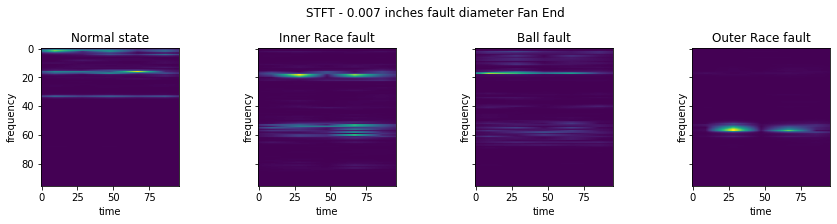

In [18]:
import matplotlib.pyplot as plt
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey = True, figsize=(12,3), constrained_layout=True)

plt1.set_xlabel("time")
plt1.set_ylabel("frequency")
plt1.set_title('Normal state')
plt1.imshow(generate_spectrogram_image(normal_data_chunk_FE_train[3], (96,96)))

plt2.set_xlabel("time")
plt2.set_ylabel("frequency")
plt2.set_title('Inner Race fault')
plt2.imshow(generate_spectrogram_image(ir_data_chunk_007_FE_train[3], (96,96)))

plt3.set_xlabel("time")
plt3.set_ylabel("frequency")
plt3.set_title('Ball fault')
plt3.imshow(generate_spectrogram_image(b_data_chunk_007_FE_train[3], (96,96)))

plt4.set_xlabel("time")
plt4.set_ylabel("frequency")
plt4.set_title('Outer Race fault')
plt4.imshow(generate_spectrogram_image(or_data_chunk_007_FE_train[3], (96,96)))

fig.suptitle('STFT - 0.007 inches fault diameter Fan End')
fig.show()

## 4.3 Image creating and Data shuffling

Several images are created that are going to be used to train the CNN. Some functions are needed to help in creating the folders in which the images will be stored and to label correctly the files generated, depending on the parameters chosen, such as `position`, `image_type`, `image_shape`, etc. 

A random shuffling is done between the chunks at this stage, so the CNN does not get trained on images that are of adjacent time windows.

Creating directory for putting the created images. These images will also be loaded from here.

In [19]:
def try_make_directories():     
    data_directories = ["dataset", "npy_dataset"]
    for directory in data_directories:
        try:
            os.makedirs(f'./{directory}')
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [20]:
from tqdm.notebook import tqdm
from enum import Enum
#
def create_image_by_label_database(
        position,
        image_types,
        image_shape,
        noise_scale = 0.0,
        shuffle_across_time=True,
        overwrite_existing_file=False):

    try_make_directories()

    filename_for_images_by_labels = npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale, 
        shuffle_across_time
    )

    if overwrite_existing_file is False:
        import os
        if os.path.isfile(filename_for_images_by_labels):
            print(
                "File already exists. Use 'overwrite_existing_file' if you wish to regenerate and overwrite it. Bye.")
            return
#   
    if position == "FE_train":
      len_n = np.shape(normal_data_chunk_FE_train)[0]
      len_b_007 = np.shape(b_data_chunk_007_FE_train)[0]
      len_b_014 = np.shape(b_data_chunk_014_FE_train)[0]
      len_b_021 = np.shape(b_data_chunk_021_FE_train)[0]
      len_ir_007 = np.shape(ir_data_chunk_007_FE_train)[0]
      len_ir_014 = np.shape(ir_data_chunk_014_FE_train)[0]
      len_ir_021 = np.shape(ir_data_chunk_021_FE_train)[0]
      len_or_007 = np.shape(or_data_chunk_007_FE_train)[0]
      len_or_014 = np.shape(or_data_chunk_014_FE_train)[0]
      len_or_021 = np.shape(or_data_chunk_021_FE_train)[0]
      
      len_data = min(len_n, len_b_007, len_b_014, len_b_021, len_ir_007, len_ir_014, len_ir_021, len_or_007, len_or_014, len_or_021, number_of_chunks)
      #display(len_n, len_or, len_ir)
     
      normal_data = normal_data_chunk_FE_train
      b_data_007 = b_data_chunk_007_FE_train
      b_data_014 = b_data_chunk_014_FE_train 
      b_data_021 = b_data_chunk_021_FE_train
      ir_data_007 = ir_data_chunk_007_FE_train
      ir_data_014 = ir_data_chunk_014_FE_train
      ir_data_021 = ir_data_chunk_021_FE_train
      or_data_007 = or_data_chunk_007_FE_train
      or_data_014 = or_data_chunk_014_FE_train
      or_data_021 = or_data_chunk_021_FE_train

    elif position == "FE_test":
      len_n = np.shape(normal_data_chunk_FE_test)[0]
      len_b_007 = np.shape(b_data_chunk_007_FE_test)[0]
      len_b_014 = np.shape(b_data_chunk_014_FE_test)[0]
      len_b_021 = np.shape(b_data_chunk_021_FE_test)[0]
      len_ir_007 = np.shape(ir_data_chunk_007_FE_test)[0]
      len_ir_014 = np.shape(ir_data_chunk_014_FE_test)[0]
      len_ir_021 = np.shape(ir_data_chunk_021_FE_test)[0]
      len_or_007 = np.shape(or_data_chunk_007_FE_test)[0]
      len_or_014 = np.shape(or_data_chunk_014_FE_test)[0]
      len_or_021 = np.shape(or_data_chunk_021_FE_test)[0]
      
      len_data = min(len_n, len_b_007, len_b_014, len_b_021, len_ir_007, len_ir_014, len_ir_021, len_or_007, len_or_014, len_or_021, number_of_chunks)
      #display(len_n, len_or, len_ir)
      
      normal_data = normal_data_chunk_FE_test
      b_data_007 = b_data_chunk_007_FE_test
      b_data_014 = b_data_chunk_014_FE_test 
      b_data_021 = b_data_chunk_021_FE_test
      ir_data_007 = ir_data_chunk_007_FE_test
      ir_data_014 = ir_data_chunk_014_FE_test
      ir_data_021 = ir_data_chunk_021_FE_test
      or_data_007 = or_data_chunk_007_FE_test
      or_data_014 = or_data_chunk_014_FE_test
      or_data_021 = or_data_chunk_021_FE_test

    elif position == "DE":
      len_n = np.shape(normal_data_chunk_DE)[0]
      len_b_007 = np.shape(b_data_chunk_007_DE)[0]
      len_b_014 = np.shape(b_data_chunk_014_DE)[0]
      len_b_021 = np.shape(b_data_chunk_021_DE)[0]
      len_ir_007 = np.shape(ir_data_chunk_007_DE)[0]
      len_ir_014 = np.shape(ir_data_chunk_014_DE)[0]
      len_ir_021 = np.shape(ir_data_chunk_021_DE)[0]
      len_or_007 = np.shape(or_data_chunk_007_DE)[0]
      len_or_014 = np.shape(or_data_chunk_014_DE)[0]
      len_or_021 = np.shape(or_data_chunk_021_DE)[0]
      len_data = min(len_n, len_b_007, len_b_014, len_b_021, len_ir_007, len_ir_014, len_ir_021, len_or_007, len_or_014, len_or_021, number_of_chunks)
      #display(len_n, len_or, len_ir)
     
      normal_data = normal_data_chunk_DE
      b_data_007 = b_data_chunk_007_DE
      b_data_014 = b_data_chunk_014_DE 
      b_data_021 = b_data_chunk_021_DE
      ir_data_007 = ir_data_chunk_007_DE
      ir_data_014 = ir_data_chunk_014_DE
      ir_data_021 = ir_data_chunk_021_DE
      or_data_007 = or_data_chunk_007_DE
      or_data_014 = or_data_chunk_014_DE
      or_data_021 = or_data_chunk_021_DE
      #display(np.shape(nominal_data))

    if shuffle_across_time:
        # so the first N chunks will be taken at random time from the whole time window
        np.random.shuffle(normal_data)
        np.random.shuffle(b_data_007)
        np.random.shuffle(b_data_014)
        np.random.shuffle(b_data_021)
        np.random.shuffle(ir_data_007)
        np.random.shuffle(ir_data_014)
        np.random.shuffle(ir_data_021)
        np.random.shuffle(or_data_007)
        np.random.shuffle(or_data_014)
        np.random.shuffle(or_data_021)      
        
    images_by_labels = {'n': [], 'b_0.007inch': [], 'b_0.014inch': [], 'b_0.021inch': [], 'ir_0.007inch': [], 'ir_0.014inch': [], 'ir_0.021inch': [], 'or_0.007inch': [], 'or_0.014inch': [], 'or_0.021inch': []}
    #display(int(len_data))
    #1
    for i in tqdm(range(int(len_n))):
        n_images = generate_rgba_images_from_data(normal_data[i], image_shape, image_types)

        images_by_labels['n'].extend(n_images)
    #2
    for i in tqdm(np.arange(len_b_007)):    
        b_images_007 = generate_rgba_images_from_data(b_data_007[i], image_shape, image_types)
        
        images_by_labels['b_0.007inch'].extend(b_images_007)
    #3
    for i in tqdm(np.arange(len_b_014)):    
        b_images_014 = generate_rgba_images_from_data(b_data_014[i], image_shape, image_types)
        
        images_by_labels['b_0.014inch'].extend(b_images_014)
    #4
    for i in tqdm(np.arange(len_b_021)):    
        b_images_021 = generate_rgba_images_from_data(b_data_021[i], image_shape, image_types)
        
        images_by_labels['b_0.021inch'].extend(b_images_021)
    #5
    for i in tqdm(np.arange(len_ir_007)):
        ir_images_007 = generate_rgba_images_from_data(ir_data_007[i], image_shape, image_types)
        
        images_by_labels['ir_0.007inch'].extend(ir_images_007)
    #6
    for i in tqdm(np.arange(len_ir_014)):
        ir_images_014 = generate_rgba_images_from_data(ir_data_014[i], image_shape, image_types)
        
        images_by_labels['ir_0.014inch'].extend(ir_images_014)
    #7
    for i in tqdm(np.arange(len_ir_021)):    
        ir_images_021 = generate_rgba_images_from_data(ir_data_021[i], image_shape, image_types)
          
        images_by_labels['ir_0.021inch'].extend(ir_images_021)
    #8
    for i in tqdm(np.arange(len_or_007)):    
        or_images_007 = generate_rgba_images_from_data(or_data_007[i], image_shape, image_types)
        
        images_by_labels['or_0.007inch'].extend(or_images_007)
    #9
    for i in tqdm(np.arange(len_or_014)):    
        or_images_014 = generate_rgba_images_from_data(or_data_014[i], image_shape, image_types)
        
        images_by_labels['or_0.014inch'].extend(or_images_014)
    #10
    for i in tqdm(np.arange(len_or_021)):    
        or_images_021 = generate_rgba_images_from_data(or_data_021[i], image_shape, image_types)
        
        images_by_labels['or_0.021inch'].extend(or_images_021)

    print(f'Saving {filename_for_images_by_labels}')
    np.save(f'{filename_for_images_by_labels}', images_by_labels)
        
#
def npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale,
        shuffled_across_time):
    filename_suffix = \
        (f'_Position_{position}') + \
        f'_types{"-".join([str(t)[10:12] for t in image_types])}' + \
        (f'_noise{noise_scale}' if noise_scale > 0 else '') + \
        (f'_timeshuffled' if shuffled_across_time else '') + \
        f'_shape{image_shape[0]}-{image_shape[1]}'
    filename = f'./npy_dataset/images_by_labels_for_cnn{filename_suffix}.npy'
    return filename
#
#
def generate_rgba_images_from_data(
        vector_y_data,
        image_shape,
        image_types):
    images = []
    if ImageType.SPECTROGRAM in image_types:
        images.append(generate_spectrogram_image(vector_y_data, image_shape))

    images_rgba = ary_to_rgba(images)

    return images_rgba
#
#
def ary_to_rgba(ary, nchannels=1):
    from matplotlib import cm

    ary_dim = (np.shape(ary))

    im = np.empty(shape=(ary_dim[0], ary_dim[1], ary_dim[2], nchannels)).astype('uint8')
    for i in np.arange(0, len(ary)):
        im[i, :] = np.log(ary[i] + 1e-6).reshape(ary_dim[0], ary_dim[1], ary_dim[2], nchannels)
    return im
#

class ImageType(Enum):
    SCALOGRAM = 1
    SPECTROGRAM = 2
    QTRANSFORM = 3

### 4.3.1 Image creating
The parameters of the preprocessing are: 

Transfer Learning 
- Source Domain = 12k DE data for train

In [21]:
create_image_by_label_database(
    position="DE", 
    image_types=[ImageType.SPECTROGRAM], 
    image_shape=(96, 96), 
    shuffle_across_time=True,
    overwrite_existing_file=True)


Saving ./npy_dataset/images_by_labels_for_cnn_Position_DE_typesSP_timeshuffled_shape96-96.npy


Transfer Learning 
- Target Domain = 90% 12k FE data for Test

In [22]:
create_image_by_label_database(
    position="FE_test", 
    image_types=[ImageType.SPECTROGRAM], 
    image_shape=(96, 96), 
    shuffle_across_time=True,
    overwrite_existing_file=True)


Saving ./npy_dataset/images_by_labels_for_cnn_Position_FE_test_typesSP_timeshuffled_shape96-96.npy


## 4.4 Preparing Train-Test Data 

### 4.4.1 Image loading
Now to define a function that loads the images that were generated.


In [23]:
def load_images_by_labels_by_params(
        position,
        image_types ,
        image_shape,
        noise_scale = 0.0,
        chunks_are_shuffled_across_time=True):
    filename = npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale,
        chunks_are_shuffled_across_time)

    loaded = np.load(filename, allow_pickle=True)
    print(f"Successfully loaded file {filename}")
    return loaded.item()  # item() gets the actual dictionary from the loaded object

With the aid of the previous function the images for *DE* and *train* is loaded

In [24]:
position = "DE"
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn_train = load_images_by_labels_by_params(
    position=position,    
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn_Position_DE_typesSP_timeshuffled_shape96-96.npy


With the aid of the previous function the images for *FE* and *test* is loaded. This is the *test split* of 90%.

In [25]:
position = "FE_test"
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn_test = load_images_by_labels_by_params(
    position=position,    
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn_Position_FE_test_typesSP_timeshuffled_shape96-96.npy


### 4.4.2 Image separation
Now, to transform the data to be suitable for the CNN input:
- the images and their labels need to be separated into two arrays, correlated by their indices
- the labels are to be one-hot encoded (i.e. label "N" becomes (0,0,0,0,0,0,0,0,0,1))


In [27]:
#from Zipfile import zip
#import zip
from itertools import zip_longest

def separate_images_from_labels(images_by_labels, interleave: bool):
    all_labels = list(images_by_labels.keys())
    
    NB_CLASSES = len(all_labels)
    all_labels_onehot = np.identity(NB_CLASSES).astype('uint8')
    label_to_onehot_mapper = {all_labels[i]: all_labels_onehot[i] for i in np.arange(NB_CLASSES)}

    all_images_for_cnn = []
    all_labels_for_cnn_onehot = []

    for key in all_labels:
        images = images_by_labels[key]
        labels_onehot = np.full(shape=(len(images), NB_CLASSES), fill_value=label_to_onehot_mapper[key])

        all_images_for_cnn.append(images)
        all_labels_for_cnn_onehot.append(labels_onehot)

    if interleave:
        all_images_for_cnn = lists_interleave(all_images_for_cnn)
        all_labels_for_cnn_onehot = lists_interleave(all_labels_for_cnn_onehot)
    else:  # flatten the lists
        all_images_for_cnn = [image for sublist in all_images_for_cnn for image in sublist]
        all_labels_for_cnn_onehot = [label for sublist in all_labels_for_cnn_onehot for label in sublist]

    return np.array(all_images_for_cnn), np.array(all_labels_for_cnn_onehot)
                               
def lists_interleave(lists):
    return [val for tup in zip(*lists) for val in tup]

The last step before training is to separate the images into training set and testing set. Then to separate the images and their corresponding labels.

In [28]:
images_train_1, labels_train_1_onehot = separate_images_from_labels(images_by_labels_for_cnn_train, interleave=False)
images_test, labels_test_onehot = separate_images_from_labels(images_by_labels_for_cnn_test, interleave=False)

display(type(images_train_1))
display(images_train_1.shape)
display(type(images_by_labels_for_cnn_train))

numpy.ndarray

(6697, 96, 96, 1)

dict

### 4.4.3 Image and label shuffling
Additionally, for a good distribution of data types accross the training and test data, the data is interleaved. All of the 10 types of data and random shuffle while keeping the labels for values intact.

A single array is taken, containing all the images, where sequential images are always of a different data type (N, IR1, IR2, IR3, B1, B2, B3, OR1, OR2, OR3) in the form [..., "N", "IR1", "IR2", "IR3", "B1", "B2", "B3", "OR1", "OR2", "OR3", "N", "IR1", "IR2", "IR3", ...].

In [29]:
random_idx = np.random.permutation(np.arange(0,images_train_1.shape[0]))
random_idx_test = np.random.permutation(np.arange(0,images_test.shape[0]))

In [30]:
images_train_1 = images_train_1[random_idx]
labels_train_1_onehot = labels_train_1_onehot[random_idx]

images_test = images_test[random_idx_test]
labels_test_onehot = labels_test_onehot[random_idx_test]

## 4.5 **Convolutional Neural Network**
The CNN architecture used in this notebook is from the paper [Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings](https://www.hindawi.com/journals/sv/2017/5067651/). It is a proposed architecture. 
This architecture is used due to the resolution of the image and it yields very good results in terms of precision.

### 4.5.1 CNN model with Keras
It is a supervised classification problem, with 10 classes. A Convolutional Neural Network (CNN) is implemented as a Sequential Keras model. This Keras model uses TensorFlow as backend for the tensor arithmetics. 

The images that were previously generated, form a tuple `(number of images, x dpi, y dpi, number of channels)`. The *loss function* is **categorical cross-entropy**, the *optimizer* is **ADAM** and **Leaky RELU** *activation function* is used after each Convolution layer. The *learning rate* has been tested to different values and in the end learning rate decay was followed for that matter.

In [31]:
from keras import optimizers

## input data parameters
IMAGES_SHAPE = (96, 96, 1)
PADDING = 'same'
KERNEL_SIZE = (3, 3)
KERNEL_INITIALIZER = 'glorot_normal'
# parameters for deep layers
NUMBER_OF_CLASSES = 10  # N, B 0.007inch, B 0.014inch, B 0.021inch, IR 0.007inch, IR 0.014inch, IR 0.021inch, OR 0.007inch, OR 0.014inch and OR 0.021inch  
DROPOUT = 0.4
LEAK_ALPHA = 0.1 #slope of leaky relu
MAX_POOLING_POOL_SIZE = (2, 2)
ACTIVATION_LAYER_FUNCTION = 'softmax'
# loss and optimizer
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 0.001 #default = 0.001
OPTIMIZER = optimizers.Adam(LEARNING_RATE, epsilon=10e-6)

In [32]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras import metrics


# CNN architecture from Guo et al.
model = Sequential()
model.add(Conv2D(16, KERNEL_SIZE,                  
                 input_shape=IMAGES_SHAPE,
                 data_format='channels_last',
                 kernel_initializer=KERNEL_INITIALIZER,                 
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(16, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(32, KERNEL_SIZE,                  
                 kernel_initializer=KERNEL_INITIALIZER,                 
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(32, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(64, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(64, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(128, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(128, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(100))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(NUMBER_OF_CLASSES))
model.add(Activation(ACTIVATION_LAYER_FUNCTION))
  
model.compile(loss=LOSS_FUNCTION, 
              optimizer=OPTIMIZER,
              metrics=[metrics.categorical_accuracy])  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48, 48, 32)        0

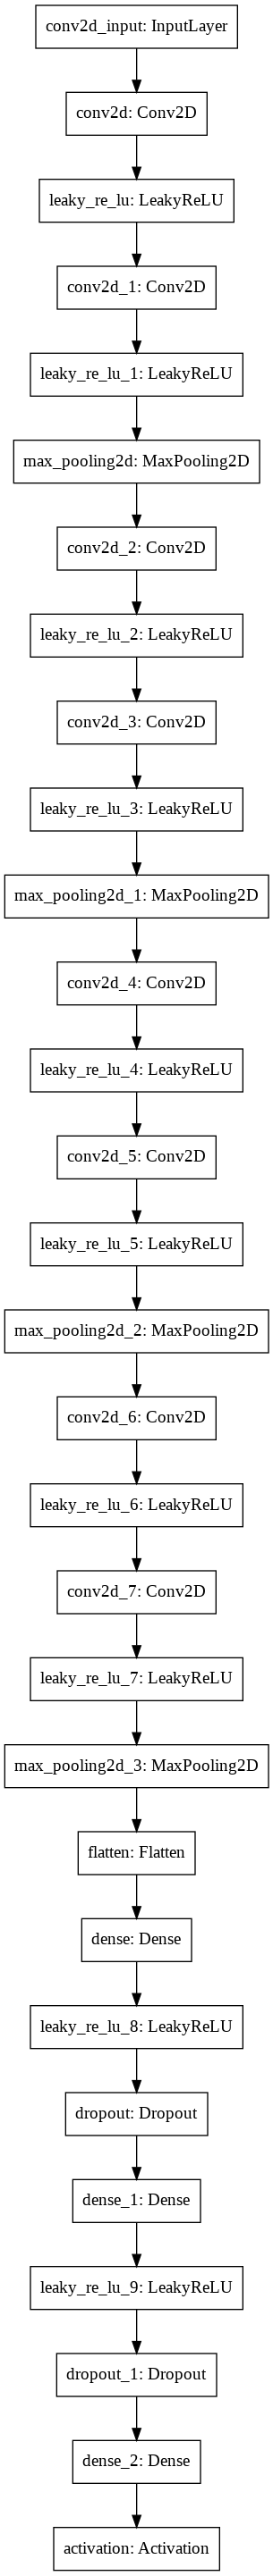

In [33]:
keras.utils.plot_model(model, "my_first_model.png")

### 4.5.2 Training the CNN

The train for CNN is with a validation split of 10% - 90% train and test respectively of the *image batch size* and over 50 epochs. The CNN will be then tested on the hold-out data. 

The Train Data is the *Source Domain* and the Validation is part of Test data or *Transfer/Target Domain*.



In [35]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [36]:
BATCH_SIZE = 80
NUMBER_OF_EPOCHS = 50
#callbacks=[callback]

history = model.fit(
    images_train_1, labels_train_1_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_data=(images_test, labels_test_onehot), 
    verbose=1)

Epoch 1/50
84/84 [==============================] - 38s 52ms/step - loss: 2.6472 - categorical_accuracy: 0.2657 - val_loss: 4.9735 - val_categorical_accuracy: 0.2949
Epoch 2/50
84/84 [==============================] - 3s 41ms/step - loss: 0.7980 - categorical_accuracy: 0.7373 - val_loss: 7.3655 - val_categorical_accuracy: 0.2799
Epoch 3/50
84/84 [==============================] - 3s 41ms/step - loss: 0.5442 - categorical_accuracy: 0.8036 - val_loss: 5.7861 - val_categorical_accuracy: 0.2967
Epoch 4/50
84/84 [==============================] - 3s 41ms/step - loss: 0.4503 - categorical_accuracy: 0.8396 - val_loss: 8.5647 - val_categorical_accuracy: 0.2848
Epoch 5/50
84/84 [==============================] - 3s 41ms/step - loss: 0.4101 - categorical_accuracy: 0.8496 - val_loss: 8.2017 - val_categorical_accuracy: 0.2861
Epoch 6/50
84/84 [==============================] - 3s 41ms/step - loss: 0.3660 - categorical_accuracy: 0.8685 - val_loss: 8.0613 - val_categorical_accuracy: 0.2738
Epoch 7/5

# 5.Test the CNN
Once the model has been fitted, the precision is calculated through a classical one vs many confusion matrix.

In [37]:
labels_predicted = np.argmax(history.model.predict(images_test), axis=-1)

In [38]:
# for the confusion matrix we need factorized labels 
# [1,0,0,0,0,0,0,0,0,0] -> 0 ("N")
# [0,1,0,0,0,0,0,0,0,0] -> 1 ("B 0.007inch") 
# [0,0,1,0,0,0,0,0,0,0] -> 2 ("B 0.014inch")
# [0,0,0,1,0,0,0,0,0,0] -> 3 ("B 0.021inch") 
# [0,0,0,0,1,0,0,0,0,0] -> 4 ("IR 0.007inch")
# [0,0,0,0,0,1,0,0,0,0] -> 5 ("IR 0.014inch")
# [0,0,0,0,0,0,1,0,0,0] -> 6 ("IR 0.021inch") 
# [0,0,0,0,0,0,0,1,0,0] -> 7 ("OR 0.007inch") 
# [0,0,0,0,0,0,0,0,1,0] -> 8 ("OR 0.014inch") 
# [0,0,0,0,0,0,0,0,0,1] -> 9 ("OR 0.021inch") 

labels_test_factorized = [(1*label[0]+2*label[1]+3*label[2]+4*label[3]+5*label[4]+6*label[5]+7*label[6]+8*label[7]+9*label[8]+10*label[9])-1 for label in labels_test_onehot]

from sklearn.metrics import classification_report
print(classification_report(labels_test_factorized, labels_predicted))

              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1273
           1       0.03      0.01      0.01       363
           2       0.01      0.01      0.01       365
           3       0.03      0.01      0.02       363
           4       0.05      0.07      0.06       364
           5       0.26      0.43      0.32       363
           6       0.00      0.00      0.00       363
           7       0.11      0.07      0.09      1092
           8       0.05      0.07      0.06       454
           9       0.03      0.02      0.02       362

    accuracy                           0.29      5362
   macro avg       0.12      0.17      0.14      5362
weighted avg       0.21      0.29      0.23      5362



#6. Train-Test loss and accuracy
Validation here is part of the test data.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


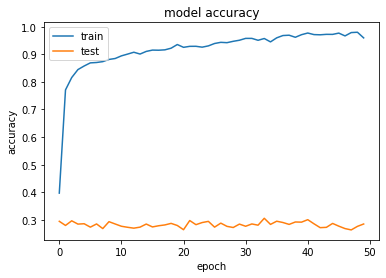

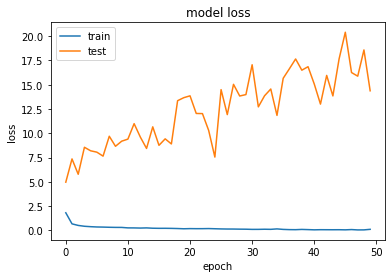

In [39]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 7.ROC analysis
The ROC curves for each class give a complete picture of the classification performance of the CNN. The function below performs this task.

In [40]:
def ROC(model, X_test, y_test, n_class):
    import seaborn as sns
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.metrics import accuracy_score, balanced_accuracy_score
    from sklearn.preprocessing import label_binarize
    from itertools import cycle
    import matplotlib.pyplot as plt
    import pandas as pd
    
    sns.set_style("dark",{"axes.facecolor": ".97"})
    # Predict the labels of the test set: y_pred
    #y_pred = model.predict_classes(X_test)
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Compute predicted probabilities: y_pred_prob
    #y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = model.predict(X_test)
    y_test_binary = label_binarize(y_test, classes=range(0, n_class))

    #0 
    #N 
    y_test_normal = y_test_binary[:, 0]
    y_prob_normal = y_pred_prob[:, 0]

    #1,2,3
    #B
    y_test_ball_007 = y_test_binary[:, 1]
    y_prob_ball_007 = y_pred_prob[:, 1]
    y_test_ball_014 = y_test_binary[:, 2]
    y_prob_ball_014 = y_pred_prob[:, 2]
    y_test_ball_021 = y_test_binary[:, 3]
    y_prob_ball_021 = y_pred_prob[:, 3]

    #4,5,6
    #IR
    y_test_inner_race_007 = y_test_binary[:, 4]
    y_prob_inner_race_007 = y_pred_prob[:, 4]
    y_test_inner_race_014 = y_test_binary[:, 5]
    y_prob_inner_race_014 = y_pred_prob[:, 5]
    y_test_inner_race_021 = y_test_binary[:, 6]
    y_prob_inner_race_021 = y_pred_prob[:, 6]

    #7,8,9
    #OR
    y_test_outer_race_007 = y_test_binary[:, 7]
    y_prob_outer_race_007 = y_pred_prob[:, 7]
    y_test_outer_race_014 = y_test_binary[:, 8]
    y_prob_outer_race_014 = y_pred_prob[:, 8]
    y_test_outer_race_021 = y_test_binary[:, 9]
    y_prob_outer_race_021 = y_pred_prob[:, 9]
    
    lw = 1.5
  
    # Compute and print the confusion matrix and classification report
    matrix_c = confusion_matrix(y_test, y_pred)
    category_labels = ['N','B 0.007 inch','B 0.014 inch','B 0.021 inch','IR 0.007 inch','IR 0.014 inch','IR 0.021 inch','OR 0.007 inch','OR 0.014 inch','OR 0.021 inch']

    matrix = pd.DataFrame(matrix_c)
    plt.figure()
    sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
    plt.xticks(rotation = 90)
    plt.show()

    # Compute accuracy score
    print("accuracy score: ", accuracy_score(y_test, y_pred))
    print("Number of correctly classified samples: ", accuracy_score(y_test, y_pred, normalize=False))
    print("balanced accuracy score: ", balanced_accuracy_score(y_test, y_pred))
    

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    fpr[0], tpr[0], thresholds[0] = roc_curve(y_test_normal, y_prob_normal)
    fpr[1], tpr[1], thresholds[1] = roc_curve(y_test_ball_007, y_prob_ball_007)
    fpr[2], tpr[2], thresholds[2] = roc_curve(y_test_ball_014, y_prob_ball_014)
    fpr[3], tpr[3], thresholds[3] = roc_curve(y_test_ball_021, y_prob_ball_021)
    fpr[4], tpr[4], thresholds[4] = roc_curve(y_test_inner_race_007, y_prob_inner_race_007)
    fpr[5], tpr[5], thresholds[5] = roc_curve(y_test_inner_race_014, y_prob_inner_race_014)
    fpr[6], tpr[6], thresholds[6] = roc_curve(y_test_inner_race_021, y_prob_inner_race_021)
    fpr[7], tpr[7], thresholds[7] = roc_curve(y_test_outer_race_007, y_prob_outer_race_007)
    fpr[8], tpr[8], thresholds[8] = roc_curve(y_test_outer_race_014, y_prob_outer_race_014)
    fpr[9], tpr[9], thresholds[9] = roc_curve(y_test_outer_race_021, y_prob_outer_race_021)

    for i in range(n_class):
        roc_auc[i] = auc(fpr[i], tpr[i])
        #display(roc_auc[i])

    # Plot all ROC curves
    plt.figure(figsize=(4, 4), dpi=150)

    colors = ['black','blue','blue','blue','red','red','red','green','green','green']
    #for i, color in zip(range(n_class), colors):
    for item in list(enumerate(colors)):
      plt.plot(fpr[item[0]], tpr[item[0]], color=item[1], lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(category_labels[item[0]], roc_auc[item[0]]))

        #plot_label=['N','B 0.007inch','B 0.014inch','B 0.021inch','IR 0.007inch','IR 0.014inch','IR 0.021inch','OR 0.007inch','OR 0.014inch','OR 0.021inch']
  
    plt.plot([0, 1], [0, 1], 'k--', lw=.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()

### 7.1 ROC curve, Confusion matrix and accuracies

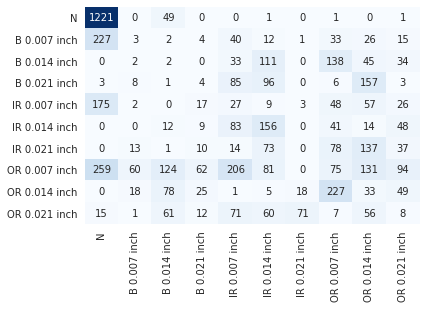

accuracy score:  0.28515479298769114
Number of correctly classified samples:  1529
balanced accuracy score:  0.16513106901367358


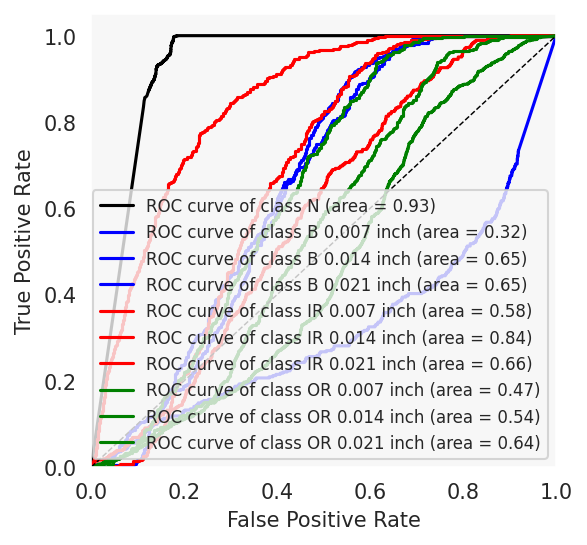

In [41]:
ROC(history.model, images_test, labels_test_factorized, 10)